# Лабораторная работа 5. Сверточные нейронные сети. Компьютерное зрение. Классификация изображений

В этой лабораторной работе мы с вами ненадолго отвлечемся от ваших наборов данных. Мы научились решать задачи регрессии и классификации с использованием самых разных моделей, однако во всех случаях данные были структурированными. Под структурированными данными мы понимаем данные, которые представлены в виде таблиц. В реальной жизни датасатанисты часто работают с более сложными данными - изображениями, текстами, аудиофайлами, видео и т.д.

Мы с вами будем решать задачу классификации изображений - научим машину определять, какой объект изображен на картинке. В процессе достижения этой цели мы рассмотрим особую архитектуру глубоких нейронных сетей (сверточные сети), поговорим про этапы предварительной обработки данных и познакомимся с такими вещами как перенос обучения (transfer learning) и тонкаяя настройка (fine-tuning). Начинаем!

## Кросс-корреляция и свертка

Первое, что нам нужно знать про изображения - любое изображение представимо в виде трехмерного массива (тензора). Почему так? Представьте картинку 300 на 300 пикселей - это уже матрица (двумерный массив). Третье измерение - это каналы. Большинство изображений кодируются как 3 матрицы - красный, зеленый и синий каналы соответственно (RGB). Если добавляется прозрачность - тогда имеем 4 канала (ARGB). Каждому каналу соответствует матрица, задающая интенсивность пикселя в данном канале (если у нас 8-битные изображения, то цвет кодируется числом от 0 до 255). 

Поскольку мы будем работать с матрицами, давайте введем две новые операции, которые и приведут нас к сверточным нейронным сетям

<b>Операция кросс-корреляции</b> выглядит следующим образом:

![](https://i.vgy.me/jTK6fj.gif)

На рисунке выше у нас есть исходная матрица input и к ней применяется так называемое <b>ядро (kernel)</b>. В результате взаимодействия с ядром получается матрица output. Давайте обозначать кросс-корреляцию символом ★.

Это мы сейчас с вами увидели так называемую <b>"valid" кросс-коррелцию</b>. Существует еще <b>"full" кросс-корреляция</b> (представлена ниже).

![](https://i.vgy.me/wGEFOe.png)

Есть еще <b>"same" кросс-корреляция</b>. Важная особенность - размер входной матрицы совпадает с размером выходной. Чтобы выполнить такую операцию как правило матрицу со всех сторон окружают нулями. К полученной матрице применяют уже обычную "valid" кросс-корреляцию. Все вот эти варианты операций называются <b>вариантами отступа (padding).</b>

Стоит также упомянуть, что нам при выполнении кросс-корреляции необязательно постоянно двигать ядро на 1 ячейку - можно двигать и на 2. Это конечно же повлияет на размер выходной матрицы и результат операции. Число, на которое мы делаем движения, называется <b>шагом (stride).</b>

<b>Операция свертки</b> - это та же самая кросс-корреляция, только ядро переворачивается на 180 градусов. Сравните рисунок ниже с самой первой картинкой. Операция свертки также может быть "valid", "full" и "same". Обозначать эту операцию мы будем через <b>*</b>.

![](https://i.vgy.me/W0aOxx.png)

Выполним эти операции с помощью scipy

In [ ]:
from scipy import signal
import numpy as np

a = np.array([
    [4, 2, 1, 5],
    [7, 3, 2, 1],
    [5, 3, 9, 4],
    [6, 6, 8, 8]
])
kernel = np.array([
    [-0.4, 3.4],
    [2, -5]
])

# кросс-корреляция
signal.correlate2d(a, kernel, "valid"), signal.correlate2d(a, kernel, "full"), signal.correlate2d(a, kernel, "same")

(array([[  4.2,  -1.4,  15.6],
        [  2.4, -33.4,   0.6],
        [ -9.8,   1.4, -14. ]]),
 array([[-20. ,  -2. ,  -1. , -23. ,  10. ],
        [-21.4,   4.2,  -1.4,  15.6,   0. ],
        [ -1.2,   2.4, -33.4,   0.6,   7.6],
        [-13. ,  -9.8,   1.4, -14. ,  14.4],
        [ 20.4,  18. ,  24.8,  24. ,  -3.2]]),
 array([[  4.2,  -1.4,  15.6,   0. ],
        [  2.4, -33.4,   0.6,   7.6],
        [ -9.8,   1.4, -14. ,  14.4],
        [ 18. ,  24.8,  24. ,  -3.2]]))

In [ ]:
# свертка
signal.convolve2d(a, kernel, "valid"), signal.convolve2d(a, kernel, "full"), signal.convolve(a, kernel, "same")

(array([[  6.6,   1.4,  11.4],
        [-13.2,  -4.4,  21. ],
        [ -1. ,  20.2, -13. ]]),
 array([[-20. ,  -2. ,  -1. , -23. ,  10. ],
        [-21.4,   4.2,  -1.4,  15.6,   0. ],
        [ -1.2,   2.4, -33.4,   0.6,   7.6],
        [-13. ,  -9.8,   1.4, -14. ,  14.4],
        [ 20.4,  18. ,  24.8,  24. ,  -3.2]]),
 array([[  4.2,  -1.4,  15.6,   0. ],
        [  2.4, -33.4,   0.6,   7.6],
        [ -9.8,   1.4, -14. ,  14.4],
        [ 18. ,  24.8,  24. ,  -3.2]]))

## Сверточные нейронные сети (CNN)

Рассмотрим сверточные нейронные сети применительно к задаче классификации изображений. Зная, что изображения - многомерные массивы, вы без труда сможете обобщить эту архитектуру сетей под разные <b>задачи, в которых входными данными являются многомерные массивы.</b>

![](https://i.vgy.me/Ufybqw.png)

Имея изначально данные размерности 3x32x32 мы проходим через так называемый <b>сверточный слой (convolutional layer)</b>, который с помощью кросс-корреляции приводит наши данные к размерности 10x32x32. Далее имеется <b>слой понижения размерности - pooling (в данном случае MaxPooling)</b>. Схема его работы представлена ниже.

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

На практике иногда используется также AveragePooling и MinPooling.

Давайте посмотрим, как производится изменение размерности на сверточном слое. Схема вышлядит следующим образом.

![](https://i.vgy.me/VY71Pa.png)

Предположим, мы хотим перейти от размерности <b>3</b>x3x3 к <b>2</b>x2x2. Чтобы это сделать, на сверточном слое инициализируется 2*3=6 ядер, в которых содержатся веса. Ядра группируются по 3 (по первой размерности входа) и для каждой группы также создается матрица сдвига (конечно же такой же размерности, как и ядра). <b>Матрицы содержат обучаемые параметры, которые мы и будем обучать в процесе оптимизации!</b>

Прямое распространение в сверточном слое, применительно к данному примеру, производится по следующей схеме.

![](https://i.vgy.me/WhdH27.png)

![](https://i.vgy.me/VnDcFz.png)

Вспомните, что звездочкой мы обозначили операцию кросс-корреляции. Формула выше реализует "valid" кросс-корреляцию. Чтобы реализовать другие виды кросс-корреляции и управлять размером выхода нужно просто дополнять при необходимости входную матрицу нулями со всех сторон.

Обучение сети реализуется методов обратного распространения ошибки, совершенно аналогично тому, как мы это делали в многослойном персептроне. Точно также на сверточном слое вычисляются градиенты по обучаемым параметрам, а также по входу. Формулы приведены ниже.

![](https://i.vgy.me/q82jZE.png)

Архитектура сверточных нейронных сетей, как правило, предполагает наличия в конце сети обычных полносвязных слоев. Переход от сверточных слоев к полносвязным производится, как правило, с помощью "вытягивания" многомерного массива в одномерный. Такаяя операция называется выравниванием, а соответствующий переходной слой <b>выравнивающим (flatten).</b>

После изменения размерности и перехода к обычным полносвязным сетям, можно разместить на самом последнем слое нужное количество нейронов и функцию активации. Таким образом, мы можем <b> решать задачи регрессии и классификации </b> для изображений с помощью сверточных нейронных сетей.

Теперь, когда мы понимаем архитектуру сети, знаем основные параметры сверточных слоев (kernel, stride и padding) а также имеем представление о вычислениях, которые выполняются в прямом и обратном распространении, мы можем пробовать решать задачу классификации.

## Классификация изображений (собираем сеть сами)

Данные для задач классификации изображени удобно хранить по следующей структуре:
- <название папки с данными>
    - папка с названием класса 1
        - <изображение 1>
        - ...
        - <изображение n1>
      ...
    - папка с названием класса d
        - <изображение 1>
        - ...
        - <изображение nd>

Все наборы данных, с которыми мы будем работать, представлены в виде такой структуры. Загрузим данные с помощью Tensorflow.

<b>Научимся отличать самолеты от мотоциклов!</b>

In [ ]:
import tensorflow as tf

При работе с изображениями удобно использовать объекты Dataset из фреймворка Tensorflow. Вот так мы можем из папки загрузить данные

In [ ]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/cv/data1", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 1598 files belonging to 2 classes.
Using 1279 files for training.
Using 319 files for validation.


Видим, что Tensorflow нашел наши картинки. Следует обратить внимание на такой параметр, как размер пакета (батча). Когда мы обучаем нейронные сети, у нас есть следующие основные стратегии извлечения объектов из обучающей выборки:
- брать по одному, считать predict, считать градиент, оптимизировать
- брать все сразу, считать predict для предикт, считать градиент усредненной функции потерь, оптимизировать
- брать батчами (в данном случае по 32 объекта), считать градиент усредненной функции потерь, оптимизировать

Мы создали объекты Dataset, которые по запросу будут выдавать по 32 изображения в ходе обучения и тестирования. Но мы можем и прямо сейчас посмотреть на картинки!

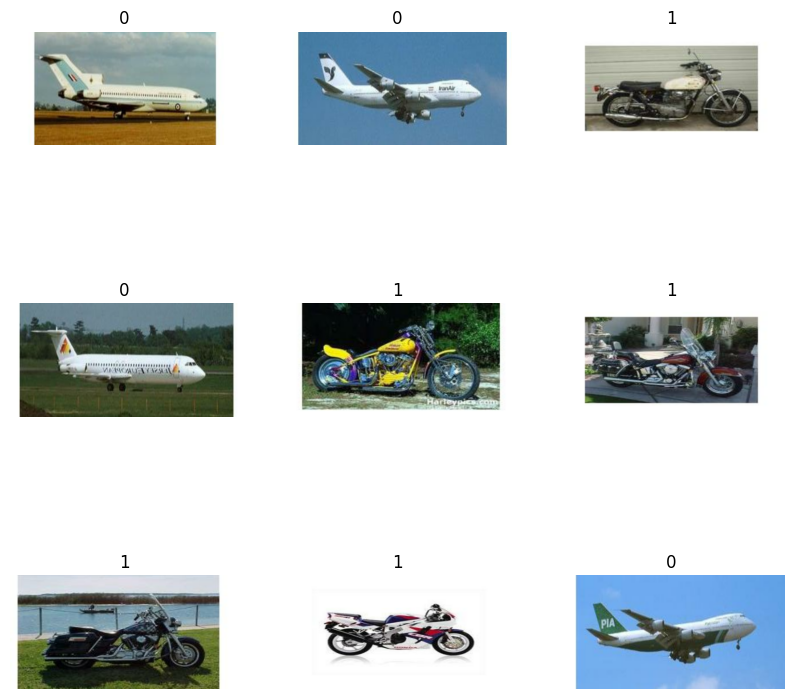

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

Видим, что нам классы еще и переименовали!

Перед сборкой сети и обучением давайте скажем несколько слов о предварительной обработке данных. Применительно к картинкам, мы можем выполнять так называемые <b>аугментации</b> данных. Это полезно, когда у нас мало изображений. В качестве примера аугментаций могут быть:
- повороты изображений;
- кадрирование изображений;
- зашумление изображений и др.

Посмотрим на пример аугментации, когда мы будем случайно изменять ориентацию изображений, а также поворачивать каждое из них на случайный угл в заданном диапазоне.

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

Обратите внимание, что аугментация реализуется как два слоя. Это подтверждает нашу с вами конепцию того, что слой - это просто функция, которая преобразует x в y. Отсюда следует еще один интересный вывод - аугментации можно заранее применить ко всем изображениям, а можно встроить в саму нейронную сеть. В первом случае, обработка аугментаций будет в любом случае происходить на CPU. А во втором случае, если у вас GPU от Nvidia и установлена CUDA - обработка аугментаций будет производиться на GPU. Без GPU можно выполнять аугментации любым способом - разницы не будет.

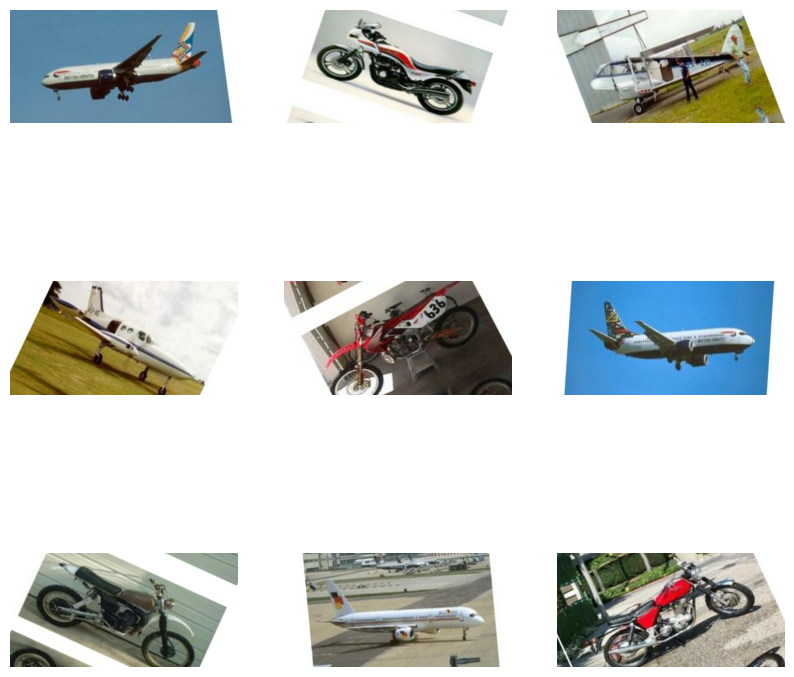

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

Ну что же, начинаем собирать сеть для классификации изображений самолетов и мотоциклов!

In [ ]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 400, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 100, 64)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 25, 128)      0         
 2D)                                                       

In [ ]:
# компилируем сеть, указываем, что будем при обучении смотреть значения accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# начинаем обучение
# указываем validation_data - при обучении будем получать accuracy для тестовой выборки
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
40/40 [==============================] - 23s 557ms/step - loss: 0.8639 - accuracy: 0.7881 - val_loss: 0.1280 - val_accuracy: 0.9498
Epoch 2/5
40/40 [==============================] - 24s 585ms/step - loss: 0.0884 - accuracy: 0.9679 - val_loss: 0.0520 - val_accuracy: 0.9843
Epoch 3/5
40/40 [==============================] - 23s 567ms/step - loss: 0.0911 - accuracy: 0.9703 - val_loss: 0.1416 - val_accuracy: 0.9498
Epoch 4/5
40/40 [==============================] - 23s 561ms/step - loss: 0.0535 - accuracy: 0.9851 - val_loss: 0.1818 - val_accuracy: 0.9373
Epoch 5/5
40/40 [==============================] - 23s 561ms/step - loss: 0.1132 - accuracy: 0.9640 - val_loss: 0.0640 - val_accuracy: 0.9749


Давайте посмотрим, как можно загрузить теперь картинку и сделать предсказание.

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "../data/cv/data1/airplanes/image_0651.jpg", target_size=(200, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 75ms/step


array([[0.9927914, 0.0072086]], dtype=float32)

Вспомним, что класс 0 - это самолеты. Мы только что научились классифицировать изображения!

## Классификация изображений (transfer learning и fine-tuning)

В современном мире мы говорим о больших нейронках, которые обучены на большом количестве данных. Не каждый может позволить себе собрать датасет из миллионов картинок, чтобы обучить качественный классификатор. В этом случае, на помощь приходит transfer learning и связанный с ним fine-tuning.

<b>Токной настройкой (fine-tuning)</b> мы называем дообучение предварительно обученной нейронной сети на других данных. Представьте себе, что вы обучили сеть вчера, сохранили ее на диск. А сегодня вы проснулись с утра и решили выполнить еще несколько эпох, но уже на других данных (чтобы повысить качество модели). Это и есть transfer learning. Обычно, под transfer learning мы понимаем дообучение больших предварительно обученных моделей, которые за нас обучили такие гиганты, как OpenAI. Google и др.

Очень часто нам нужно не только дообучить сеть на новых данных, но и изменить ее выход. Например, у нас есть сеть, способная определять изображения 10 классов. Предположим, что она обучена на миллионах приммерах и показывает невероятные результаты. Но мы хотели бы, чтобы она определяла другие классы, и чтобы не 10, а 2 например. В этом случае, мы всегда можем поменять архитектуру сети - заменить выходной слой из 10 нейронов на слой из 2 нейронов. И самое главное - заморозить все слои, кроме последнего (это называется <b>feature extraction</b>). Обратите внимание, что сеть уже предварительно обучена - найдены оптимальные веса. Нам достаточно просто найти оптимальные веса для только что добавленного слоя.

Feature extraction и fine-tuning являются возможными сценариями <b>переноса обучения (transfer learning)</b>. Их можно (и желательно) комбинировать.

Стоит сказать, что часто замораживают не все слои, кроме последнего. Иногда бывает полезно разморозить один из скрытых слоев и дополнительно оптимизировать его обучаемые параметры.

Давайте возьмем предварительно обученную сверточную нейронную сеть VGG19, она есть в Tensoflow. Она была обучена на огромном датасете imagenet и может определять изображения 1000 классов. Авторами сети являются специалисты Google. Но нам не нужны это 1000 классов! Давайте научим сеть различать такие классы, как:
- аккордионы
- бабочки
- крабы

Важно: входные изображения в VGG19 имеют размер 224x224 пикселей, что можно будет увидеть в summary. Поэтому будем приводить изображения к данному размеру.

In [ ]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/cv/data2", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 219 files belonging to 3 classes.
Using 187 files for training.
Using 32 files for validation.


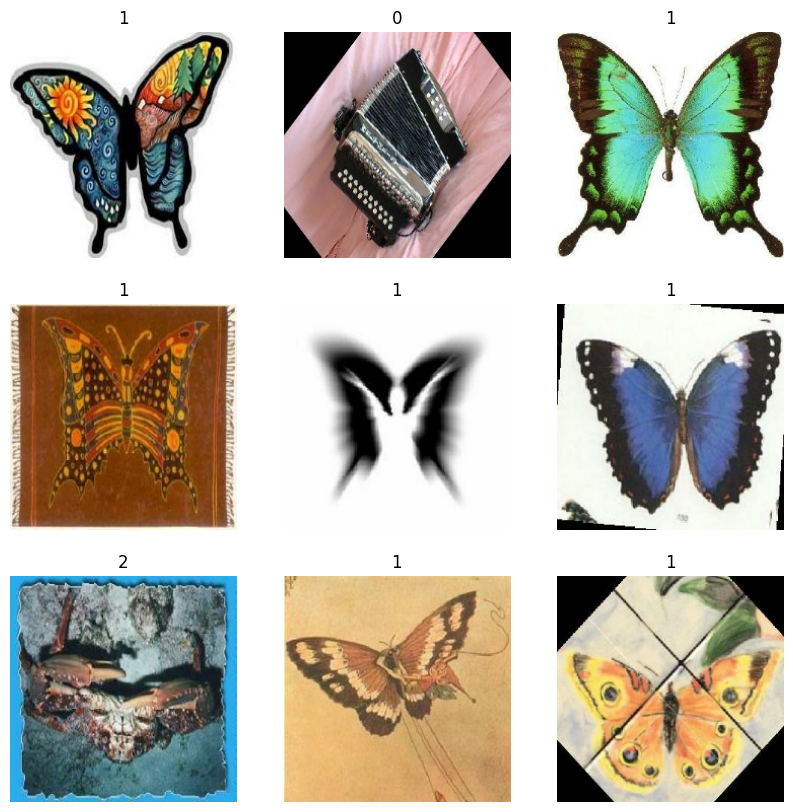

In [ ]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [ ]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

На выходном слое сети сейчас 1000 нейронов (по количеству классов). Давайте заменим его на слой из 3 нейронов.

In [ ]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [ ]:
# посмотрим, что изменилось
model_new.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# "заморозим" все слои, кроме последнего
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True

In [ ]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
6/6 [==============================] - 35s 6s/step - loss: 0.5823 - accuracy: 0.8128 - val_loss: 0.0616 - val_accuracy: 1.0000
Epoch 2/5
6/6 [==============================] - 38s 7s/step - loss: 0.0748 - accuracy: 0.9733 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 3/5
6/6 [==============================] - 36s 6s/step - loss: 0.0310 - accuracy: 0.9893 - val_loss: 0.0433 - val_accuracy: 0.9688
Epoch 4/5
6/6 [==============================] - 36s 6s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9688
Epoch 5/5
6/6 [==============================] - 37s 6s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 0.9688


Посмотрим, что получилось

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "../data/cv/data2/crab/image_0054.jpg", target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
predictions

1/1 [==============================] - 0s 225ms/step


array([[2.2968349e-09, 1.0967071e-03, 9.9890327e-01]], dtype=float32)

Видим, что теперь сеть может распознавать наши классы. И делает это очень неплохо!

Transfer learning и fine-tuning сегодня используются для самых разнообразных моделей в задачах компьютерного зрений и обработки естественного языка.

## Полезные ресурсы

Объяснение архитектуры сверточных нейронных сетей на русском языке: https://www.youtube.com/watch?v=CEUNTRdLhKk&list=PLA0M1Bcd0w8yv0XGiF1wjerjSZVSrYbjh&index=16&ab_channel=selfedu 

Полный гайд по CNN: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


## Задание

1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip. Выберите 3 любых класса, которые вам нравятся.
3. Загрузите данные и сформируете датасет. Выполните минимум две аугментации. Соберите сверточную нейронную сеть с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Оцените модель. Будьте готовы ответить на вопросы:
    - какие этапы предварительной обработки данных вы делаете и что происходит с данными?
    - что означают параметры, которые вы задаете?
    - какие слои у вас есть и что происходит на каждом слое?
    
<b>Обращаю внимание: </b> допускается несдача ЛР даже если все сделано правильно, но на вопросы ответы не предоставлены (либо неверны).

4. Загрузите модели InceptionV3 и VGG19 с помощью Tensorflow. Выполните transfer learning и fine-tuning этих моделей для распознавания выбранных на 2 пункте классов. В процессе подготовки сетей, разморозьте какой-либо еще слой, кроме последнего. Сравните результаты двух сетей на ваших данных (по метрике accuracy в процессе обучения).
5. Используйте реализацию многослойного персептрона из ЛР 4. Реализуйте сверточный слой (прямое и обратное распространение). Соберите сверточную сеть. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации сверточной нейронной сети. Вам также потребуется реализовать слой для преобразования многомерных массивов данных в одномерные.

## Дополнительное задание

Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

$y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  